In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu từ file CSV
data = pd.read_csv('../../data/ai4i2020.csv')
features = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
labels = data['Machine failure']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train = scaled_features[labels == 0][:8000]  # Dữ liệu huấn luyện bình thường
X_test = scaled_features  # Dữ liệu kiểm tra (bao gồm cả bình thường và bất thường)
y_test = labels.values

# Chuyển đổi sang Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 2. Định nghĩa VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decoder(z)
        return x_hat, mean, logvar, z

# 3. Định nghĩa Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 4. Khởi tạo mô hình và optimizer
input_dim = X_train.shape[1]
latent_dim = 5  # Kích thước latent space

vae = VAE(input_dim, latent_dim)
discriminator = Discriminator(latent_dim)

optimizer_vae = optim.Adam(vae.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# 5. Huấn luyện VAE-GAN
epochs = 150
batch_size = 32
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    vae.train()
    d_loss_total, g_loss_total = 0, 0

    for x in train_loader:
        # Huấn luyện VAE
        optimizer_vae.zero_grad()
        x_hat, mean, logvar, z = vae(x)
        recon_loss = nn.MSELoss()(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        vae_loss = recon_loss + kl_loss
        vae_loss.backward()
        optimizer_vae.step()

        # Huấn luyện Discriminator
        optimizer_d.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        noise = torch.randn(batch_size, latent_dim)
        fake_data = vae.decoder(noise)

        real_loss = nn.BCELoss()(discriminator(noise), real_labels)
        fake_loss = nn.BCELoss()(discriminator(fake_data.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Huấn luyện Generator (VAE)
        optimizer_vae.zero_grad()

        # Tách latent vector `z` khỏi đồ thị trước khi dùng cho Discriminator
        z = z.detach()
        g_loss = nn.BCELoss()(discriminator(z), real_labels)

        # Không cần retain_graph=True nếu đồ thị được tách đúng cách
        g_loss.backward()  
        optimizer_vae.step()

        d_loss_total += d_loss.item()
        g_loss_total += g_loss.item()

    print(f'Epoch [{epoch + 1}/{epochs}], d_loss: {d_loss_total:.4f}, g_loss: {g_loss_total:.4f}')



Epoch [1/150], d_loss: 290.0799, g_loss: 153.7688
Epoch [2/150], d_loss: 201.7687, g_loss: 100.6748
Epoch [3/150], d_loss: 120.1754, g_loss: 58.8443
Epoch [4/150], d_loss: 69.8303, g_loss: 35.6629
Epoch [5/150], d_loss: 44.5869, g_loss: 22.3368
Epoch [6/150], d_loss: 30.2661, g_loss: 16.7230
Epoch [7/150], d_loss: 21.4563, g_loss: 11.8496
Epoch [8/150], d_loss: 16.6912, g_loss: 9.6858
Epoch [9/150], d_loss: 13.5115, g_loss: 7.7762
Epoch [10/150], d_loss: 11.2288, g_loss: 6.0148
Epoch [11/150], d_loss: 9.5505, g_loss: 5.0979
Epoch [12/150], d_loss: 7.4521, g_loss: 4.3710
Epoch [13/150], d_loss: 7.0154, g_loss: 3.5105
Epoch [14/150], d_loss: 5.2307, g_loss: 4.0940
Epoch [15/150], d_loss: 4.9596, g_loss: 2.3004
Epoch [16/150], d_loss: 4.3785, g_loss: 3.1390
Epoch [17/150], d_loss: 4.0799, g_loss: 1.7503
Epoch [18/150], d_loss: 3.1973, g_loss: 1.8788
Epoch [19/150], d_loss: 3.1312, g_loss: 1.6568
Epoch [20/150], d_loss: 2.6914, g_loss: 1.4674
Epoch [21/150], d_loss: 2.2595, g_loss: 1.2976


Ngưỡng phát hiện: 2.127124512195587
Confusion Matrix:
 [[9062  599]
 [ 238  101]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      9661
           1       0.14      0.30      0.19       339

    accuracy                           0.92     10000
   macro avg       0.56      0.62      0.58     10000
weighted avg       0.95      0.92      0.93     10000

ROC AUC Score: 0.6179666200418372


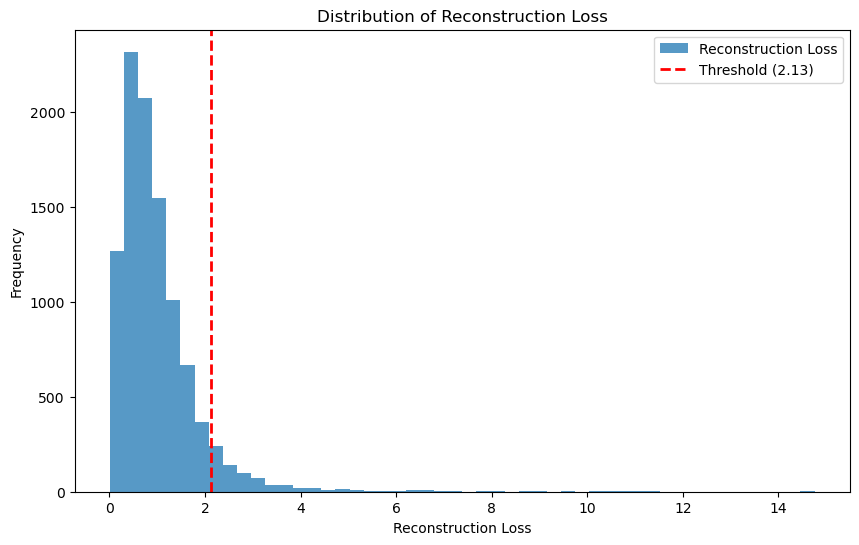

In [15]:


# 6. Dự đoán trên tập kiểm tra
vae.eval()
with torch.no_grad():
    x_hat, _, _, _ = vae(X_test_tensor)
    reconstruction_loss = torch.mean((X_test_tensor - x_hat) ** 2, dim=1).numpy()

# 7. Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)
print(f"Ngưỡng phát hiện: {threshold}")

# 8. Dự đoán bất thường
y_pred = (reconstruction_loss > threshold).astype(int)

# 9. In Confusion Matrix và Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 10. Tính ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# 11. Vẽ biểu đồ của reconstruction_loss và ngưỡng
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, alpha=0.75, label='Reconstruction Loss')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Loss')
plt.legend()
plt.show()
